<h1 style="text-align: center;">Berkeley Haas Capstone Project</h1>


<u><h2>Ad-Click Prediction</h2></u>

<p><b>Author:</b> Yash Bhargava<br/><b>Date:</b> 11/16/2024</p>

<u><h2>Research Question</h2></u>

<p>Predict whether a user will click on an advertisement based on their browsing behavior and ad features.</p>

<u><h2>Data Source(s)</h2></u>

<p>The dataset being used is <a href="https://www.kaggle.com/datasets/marius2303/ad-click-prediction-dataset?resource=download">Ad Click Prediction Dataset</a> from Kaggle.com.</p>

<h3>About Dataset</h3>
<p>This dataset captures key aspects of user behavior and online advertising, aiming to predict whether a user will engage with an advertisement by clicking on it. It includes information on user demographics, browsing activities, and specific attributes of the displayed advertisement.</p>
<p>There are 9 features: 
    <ul>
        <li>id: Unique identifier for each user.</li>
        <li>full_name: User's name formatted as "UserX" for anonymity.</li>
        <li>age: Age of the user (ranging from 18 to 64 years).</li>
        <li>gender: The gender of the user (categorized as Male, Female, or Non-Binary).</li>
        <li>device_type: The type of device used by the user when viewing the ad (Mobile, Desktop, Tablet).</li>
        <li>ad_position: The position of the ad on the webpage (Top, Side, Bottom).</li>
        <li>browsing_history: The user's browsing activity prior to seeing the ad (Shopping, News, Entertainment, Education, Social Media)</li>
        <li>time_of_day: The time when the user viewed the ad (Morning, Afternoon, Evening, Night).</li>
        <li>click: The target label indicating whether the user clicked on the ad (1 for a click, 0 for no click).</li>
    </ul>
</p>

<p>Note: The dataset previously chosen to be used has changed. Before, the dataset to be used was <a href="https://www.kaggle.com/c/avazu-ctr-prediction/data">Click-Through Rate Prediction</a></p>

<u><h2>Methodology</h2></u>
<p>The methodology involved several steps including:
    <li>Data preprocessing to clean and prepare data.</li>
    <li>Feature engineering and transformation to make features suitable for modeling.</li>
    <li>Model training and evaluation using Logistic Regression, Decision Trees, and Random Forest.</li>
    <li>Hyperparameter tuning to optimize each model's performance.</li>
</p>
<h3>Import Libraries</h3>

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

<h3>Load Data</h3>

In [10]:
ads = pd.read_csv('dataset/ad_click_dataset.csv')

ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.3+ KB


In [11]:
ads.describe()

,id,age,click
count,10000.000000,5234.000000,10000.000000
mean,5060.211400,40.197363,0.650000
std,2861.758265,13.126420,0.476993
min,5.000000,18.000000,0.000000
25%,2529.000000,29.000000,0.000000
50%,5218.000000,39.500000,1.000000
75%,7466.000000,52.000000,1.000000
max,10000.000000,64.000000,1.000000


In [12]:
ads.head()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


In [13]:
# Find all columns that have missing data
missing_cols = []
for col in ads.columns:
    missing_sum = ads[col].isnull().sum()
    if (missing_sum > 0):
        missing_cols.append(col)

missing_cols

['age',
 'gender',
 'device_type',
 'ad_position',
 'browsing_history',
 'time_of_day']

In [14]:
# Percentages of missing values for these columns
percentages = []
for col in missing_cols:
    percentages.append((ads[col].isnull().sum() / ads.shape[0]) * 100)

missing_df = pd.DataFrame({'column': missing_cols,
                         'percentages_missing': percentages})

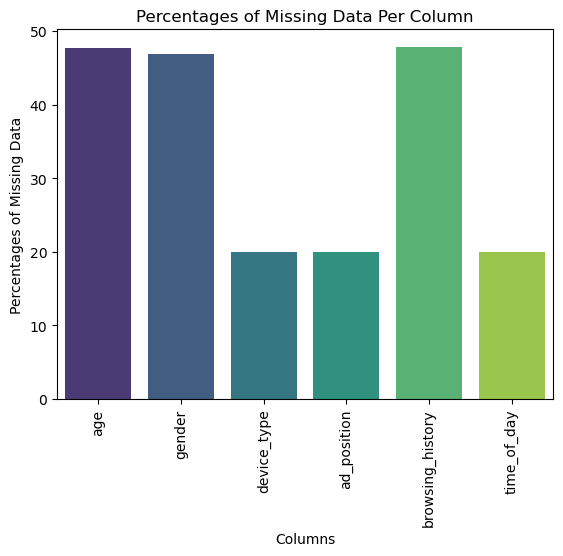

In [15]:
# Plot percentages missing data per column
sns.barplot(x='column', y='percentages_missing', data=missing_df, hue='column', palette='viridis')
plt.xlabel('Columns')
plt.xticks(rotation = 90)
plt.ylabel('Percentages of Missing Data')
plt.title('Percentages of Missing Data Per Column')
plt.show()

<p>According to the graph, we see that a lot of data is missing for 3 columns: age, gender, browsing_history. For all of the missing data however, we will replace with the mean (age) and most frequent (all other columns).</p>

<h3>Feature Exploration</h3>

In [18]:
# Function to make plotting easier by feature
def feature_plot(feature):
    plt.subplots(figsize=(14,6))
    sns.countplot(data=ads, x=feature, hue = 'click', palette='hls')
    plt.xlabel(f'{feature}')
    plt.xticks(rotation = 90)
    plt.ylabel('Count')
    plt.title(f'Distribution of {feature}')
    plt.show()

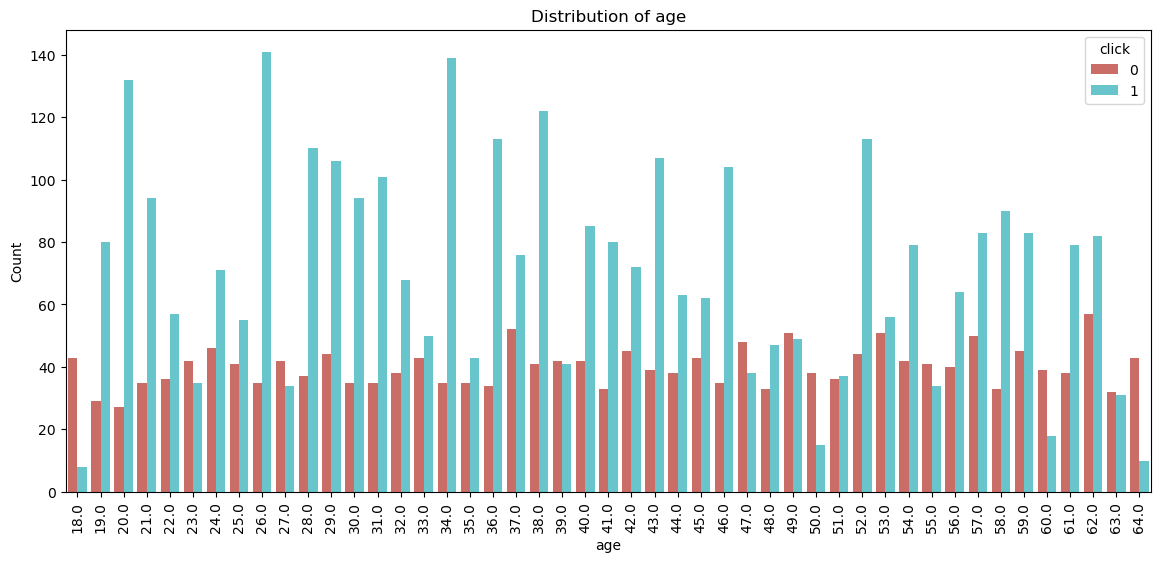

In [19]:
feature_plot('age')

<p>The plot above shows a distribution of age between those who clicked an ad, and those who did not. It seems that the click behavior is higher toward between ages 20-35, and slightly lower onward.</p>

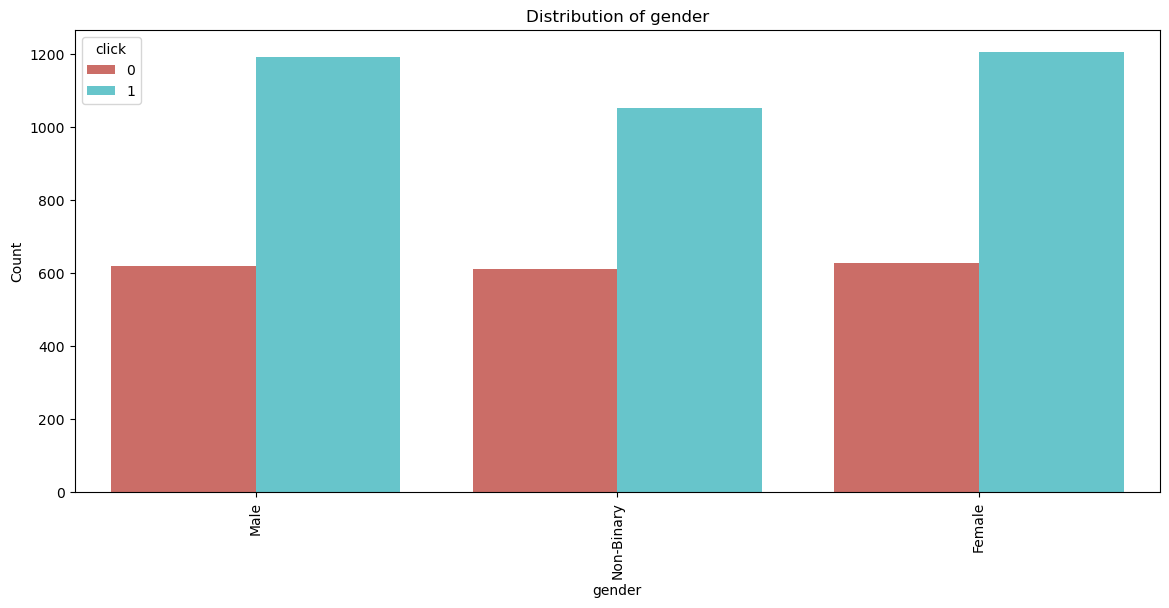

In [21]:
feature_plot('gender')

<p>The plot above shows the distribution of people who clicked/did not click an ad based on gender. We can say that the distribution is pretty even across the genders.</p>

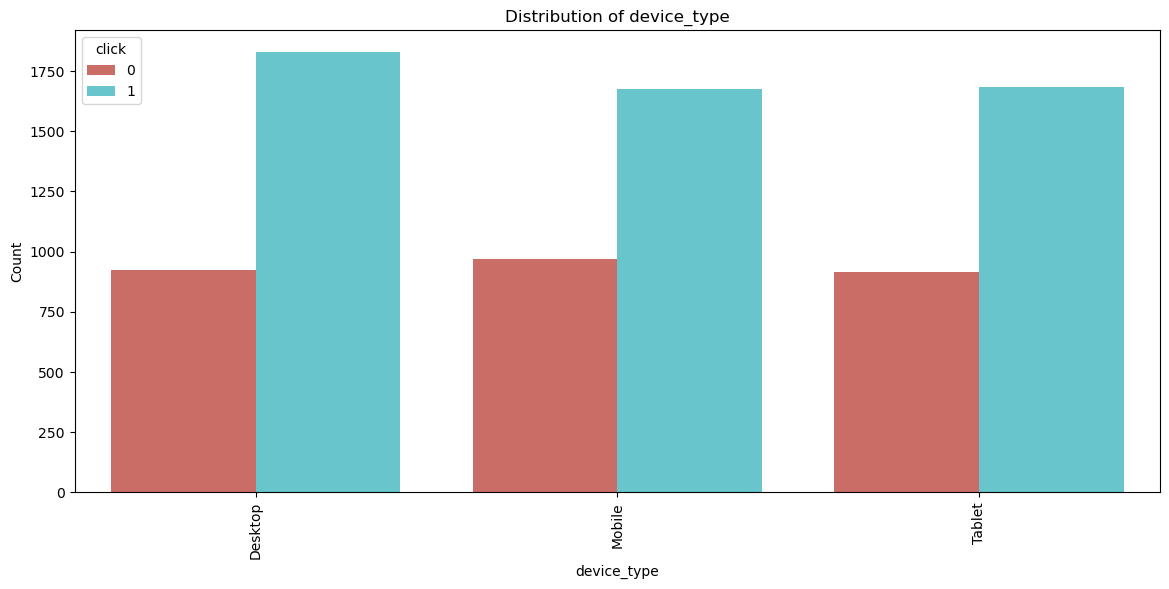

In [23]:
feature_plot('device_type')

<p>The plot above shows distribution of clicked ads/not clicked ads based on device type, and in this case Desktop has highest clicks.</p>

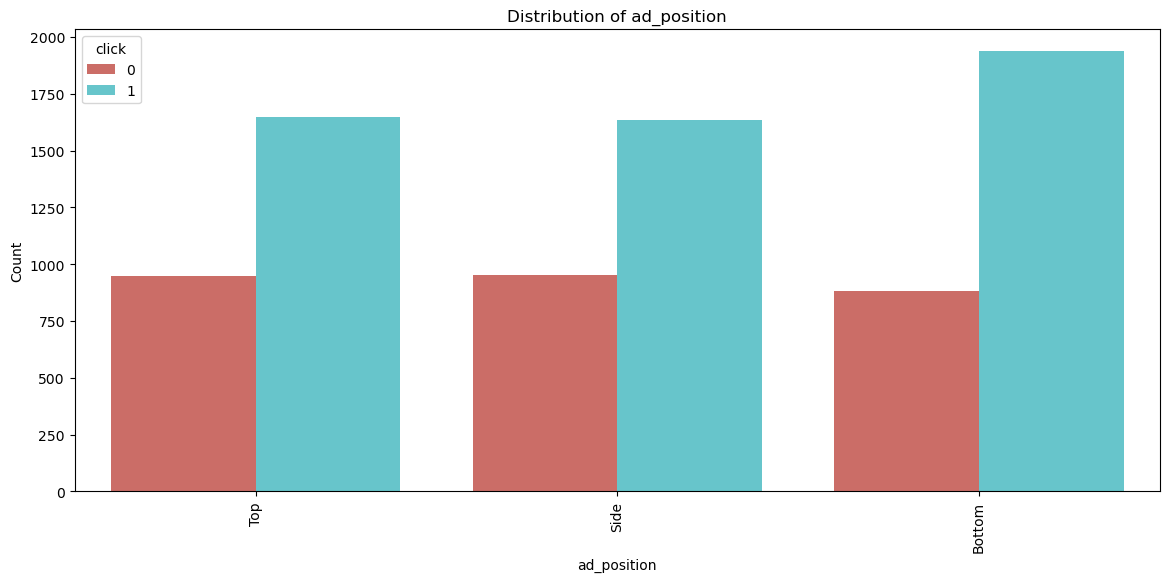

In [25]:
feature_plot('ad_position')

<p>Plot above shows distribution of clicked ads/not clicked ads based on position of the ad, and shows that bottom of the page/site is when the ad had most clicks.</p>

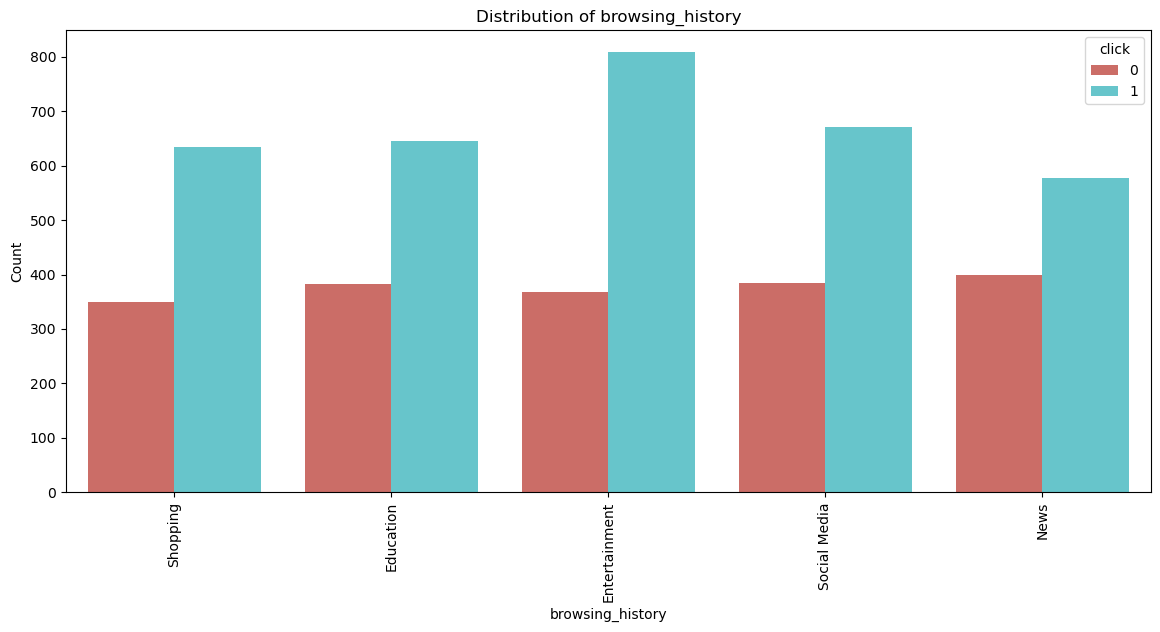

In [27]:
feature_plot('browsing_history')

<p>Plot above shows distribution of clicked ads/not clicked ads based on browsing history, and shows that entertainment was the most popular activity before an ad was clicked.</p>

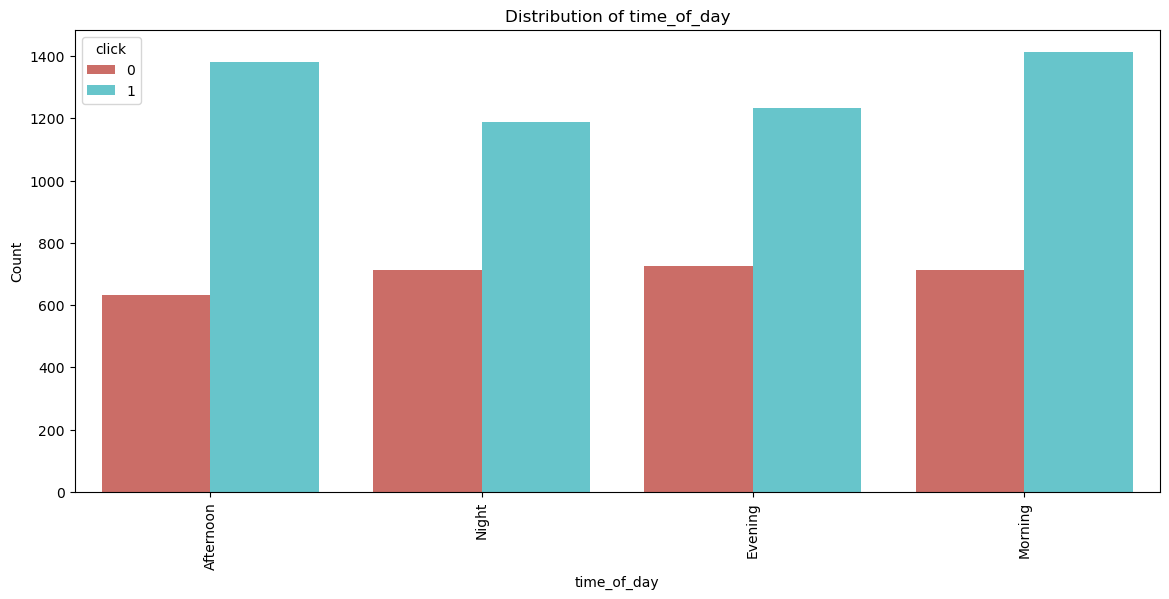

In [29]:
feature_plot('time_of_day')

<p>Plot above shows distribution of clicked ads/not clicked ads based on time of the day, and shows that more ad clicks occurred during morning/afternoon time.</p>

<h3>Data Preprocessing</h3>
<h4>Data Cleaning</h4>

<p>Steps: <ol>
    <li>Drop irrelevant columns (id, full_name)</li>
    <li>Split the data into training and testing sets</li>
    <li>Handle missing values</li>
    <li>Encode categorical features</li>
    <li>Scale numerical features</li>
    </ol>

Data is split into training and testing sets after dropping columns to avoid data leaking. Using global stastics to fill in missing values can be impacted if data is not split beforehand, since the test data should not be used to train models.

We will also change column types to int and category as necessary.
</p>

In [32]:
# Drop irrelevant columns
ads.drop(['id', 'full_name'], axis=1, inplace=True)

In [33]:
# Separate into features and target columns
X = ads.drop(columns=["click"])
y = ads["click"]

In [34]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Categorical and numerical columns
categorical_cols = ["gender", "device_type", "ad_position", "browsing_history", "time_of_day"]
numerical_cols = ["age"]

In [35]:
# Imputers for handling missing data - Mean for numerical data, and most frequent for categorical data
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")

In [36]:
# Apply imputers
# Numerical imputer
X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])
# Categorical imputer
X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])

In [37]:
# Transformers for scaling and encoding
num_transformer = Pipeline(steps=[("scaler", StandardScaler())])
cat_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numerical_cols),
        ("cat", cat_transformer, categorical_cols)
    ]
)

<h4>Model Building</h4>

<p>Build 3 models including Logistic Regression, Decision Trees, and Random Forest.</p>
<p>Hyperparameter tuning will be performed on these models to ensure the best model for each is used.</p>

<h5>Pipelines and Initial Cross Validation</h5>

In [40]:
# Pipelines for Logistic Regression, Decision Tree, and Random Forest
lr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

dt_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [41]:
# Cross Validation score - Without hyperparameter tuning
models = {
    "Logistic Regression": lr_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    print(f"{model_name} Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")

Logistic Regression Cross-Validation Accuracy: 0.6511
Decision Tree Cross-Validation Accuracy: 0.7255
Random Forest Cross-Validation Accuracy: 0.7184


<h5>Hyperparameter Tuning with GridSearchCV</h5>

In [43]:
# Parameters to test for hyperparameter tuning for each model
param_grid_lr = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__solver": ["liblinear", "lbfgs"], 
    "classifier__penalty": ["l2"],
}

param_grid_dt = {
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10]
}

param_grid_rf = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5, 10]
}

In [44]:
model_name = ['Logistic Regression', 'Decision Tree', 'Random Forest']
model_best_params = []
model_scores = []

<h5>Logistic Regression</h5>

In [46]:
# Grid search for Logistic Regression
grid_lr = GridSearchCV(lr_model, param_grid_lr, cv=5, scoring="accuracy")

# Fit grid search for Logistic Regression
grid_lr.fit(X_train, y_train)

# Find best parameter for Logistic Regression model
print("Best Logistic Regression Parameters:", grid_lr.best_params_)
model_best_params.append(grid_lr.best_params_)

Best Logistic Regression Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [47]:
# Test best LR model on test set
best_lr_model = grid_lr.best_estimator_

lr_predictions = best_lr_model.predict(X_test)

lr_score = accuracy_score(y_test, lr_predictions)

# Accuracy for LR model
print("Logistic Regression Test Accuracy:", lr_score)
model_scores.append(lr_score)

Logistic Regression Test Accuracy: 0.6465


<h5>Decision Tree</h5>

In [49]:
# Grid search for Decision Tree
grid_dt = GridSearchCV(dt_model, param_grid_dt, cv=5, scoring="accuracy")

# Fit grid search for Decision Tree
grid_dt.fit(X_train, y_train)

# Find best parameter for Decision Tree model
print("Best Decision Tree Parameters:", grid_dt.best_params_)
model_best_params.append(grid_dt.best_params_)

Best Decision Tree Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2}


In [50]:
# Test best DT model on test set
best_dt_model = grid_dt.best_estimator_

dt_predictions = best_dt_model.predict(X_test)

dt_score = accuracy_score(y_test, dt_predictions)
# Accuracy for DT model
print("Decision Tree Test Accuracy:", dt_score)
model_scores.append(dt_score)

Decision Tree Test Accuracy: 0.7265


<h5>Random Forest</h5>

In [52]:
# Grid search for Random Forest
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring="accuracy")

# Fit grid search for Random Forest
grid_rf.fit(X_train, y_train)

# Find best parameter for Random Forest model
print("Best Random Forest Parameters:", grid_rf.best_params_)
model_best_params.append(grid_rf.best_params_)

Best Random Forest Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [53]:
# Test best RF model on test set
best_rf_model = grid_rf.best_estimator_

rf_predictions = best_rf_model.predict(X_test)

rf_score = accuracy_score(y_test, rf_predictions)
# Accuracy for RF model
print("Random Forest Test Accuracy:", rf_score)
model_scores.append(rf_score)

Random Forest Test Accuracy: 0.715


<h2>Results</h2>

In [55]:
model_df = pd.DataFrame({
    "name": model_name,
    "best_params": model_best_params,
    "accuracy": model_scores
})

pd.set_option('display.max_colwidth', None) 
model_df

,name,best_params,accuracy
0,Logistic Regression,"{'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}",0.6465
1,Decision Tree,"{'classifier__max_depth': 20, 'classifier__min_samples_split': 2}",0.7265
2,Random Forest,"{'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}",0.7150


<p>After building 3 types of models: Logistic Regression, Decision Tree, and Random Forest, we hyperparameter tuned these models to achieve the best result possible. As a result, the best model was Decision Tree where the best parameters for this model was a max depth of 2 and min samples split of 2. The model achieved a 0.7265 or 72.65% accuracy on test data.</p>
<p>Random Forest came a close second and achieved a accuracy of 0.7150 or 71.50% accuracy on test data. Logistic Regression peformed the worst.</p>

<h3>Next Steps</h3>

Some things that can be done to further improve the model built include further hyperparamter tuning. Some hyperparameters that can be used include:

min_samples_leaf: Minimum number of samples required to be at a leaf node.
max_features: Number of features to consider when looking for the best split.
ccp_alpha: Use to reduce overfitting.

We can also examine feature importance to understand which features contribute the most and remove the less important ones if necessary.

Another step that can be taken are feature selection techniques such as recursive feature selection (RFE) to improve model focus.

Further more, model should be tested on more data.